In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import mysql.connector
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString,MultiLineString,LinearRing,Point
from shapely import symmetric_difference
from shapely.ops import nearest_points
from shapely.wkt import loads
import scipy
import time
import numpy as np
import random
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import osmnx as ox
import glob
from itertools import combinations,product
from copy import deepcopy
import os
from lib_contour_lines import *
import mysql.connector


In [2]:
def get_elevation_along_osm_path(G_osm,path,cursor):
    edge_coordinates,elevations=[],[]
    total_length=0
    for k in range(len(path)-1):
        length=G_osm.get_edge_data(path[k],path[k+1],0)['length']

        cmd="SELECT edge_coordinate,elevation FROM %s WHERE (osm_begin=%i AND osm_end=%i)"%(osm_intersections_table_name,path[k],path[k+1])
        cursor.execute(cmd)
        output=cursor.fetchall()
        if len(output)==0:
            cmd="SELECT edge_coordinate,elevation FROM %s WHERE (osm_end=%i AND osm_begin=%i)"%(osm_intersections_table_name,path[k],path[k+1])
            cursor.execute(cmd)
            output=cursor.fetchall()
            for elem in output:
                elem['edge_coordinate']=length-elem['edge_coordinate']
            
        output=sorted(output,key=lambda elem:elem['edge_coordinate'])
        edge_coordinates+=[total_length+elem['edge_coordinate'] for elem in output]
        elevations+=[elem['elevation'] for elem in output]
        total_length+=length

    return edge_coordinates,elevations

In [3]:

cnx = mysql.connector.connect(user='spirz', 
                              password='this_is_my_PASSWORD_m8',
                              host='localhost',
                              database='dem_from_contours_lines',
                              autocommit=True)
cursor = cnx.cursor(buffered=True,dictionary=True)
contours_lines_table_name='contours_lines'
osm_nodes_table_name="osm_nodes"
intersections_table_name="intersections"
2

2

In [6]:
t1=time.time()
cmd="SELECT id,edge_coordinate,elevation,osm_begin,osm_end,osm_key,ST_asText(geometry) AS geometry FROM %s"%intersections_table_name
cursor.execute(cmd)
intersection=pd.DataFrame(cursor.fetchall())
intersection=intersection.set_index('id')
intersection['geometry']=intersection['geometry'].apply(lambda pt:loads(pt))
intersection=gpd.GeoDataFrame(intersection,geometry='geometry',crs='epsg:4326')
t2=time.time()
print(t2-t1)

1.239952802658081


In [7]:
t1=time.time()
intersection['edge']=intersection.apply(lambda row:(row['osm_begin'],row['osm_end'],row['osm_key']),axis=1)
edges=intersection['edge'].unique()
edges=sorted(edges,key=lambda edge:len(intersection[intersection.edge==edge]))
t2=time.time()
print(t2-t1)

93.75992178916931


In [8]:
intersection

,edge_coordinate,elevation,osm_begin,osm_end,osm_key,geometry,edge
id,,,,,,,
1,404.6730,0.0,1814719166,3397570579,0,POINT (9.53006 42.37794),"(1814719166, 3397570579, 0)"
2,393.5600,0.0,1814719166,3397570579,0,POINT (9.53007 42.37804),"(1814719166, 3397570579, 0)"
3,51.0613,10.0,5578333872,5578333883,1,POINT (9.48095 42.54381),"(5578333872, 5578333883, 1)"
4,51.1213,10.0,5578333872,5578333883,1,POINT (9.48095 42.54381),"(5578333872, 5578333883, 1)"
5,2634.7400,25.0,2344258126,2246047444,0,POINT (9.46363 42.51484),"(2344258126, 2246047444, 0)"
...,...,...,...,...,...,...,...
84779,1271.3000,1660.0,294934188,943065370,0,POINT (9.14951 42.07859),"(294934188, 943065370, 0)"
84780,1265.8600,1660.0,294934188,943065370,0,POINT (9.14957 42.07857),"(294934188, 943065370, 0)"
84781,1244.3600,1660.0,294934188,943065370,0,POINT (9.14983 42.07856),"(294934188, 943065370, 0)"


477
41.764859663973205 9.190296592899383
41.862113684626436 9.39156911227949
min:10.000000, max:1215.000000, d+:545.000000, d-:-1410.000000


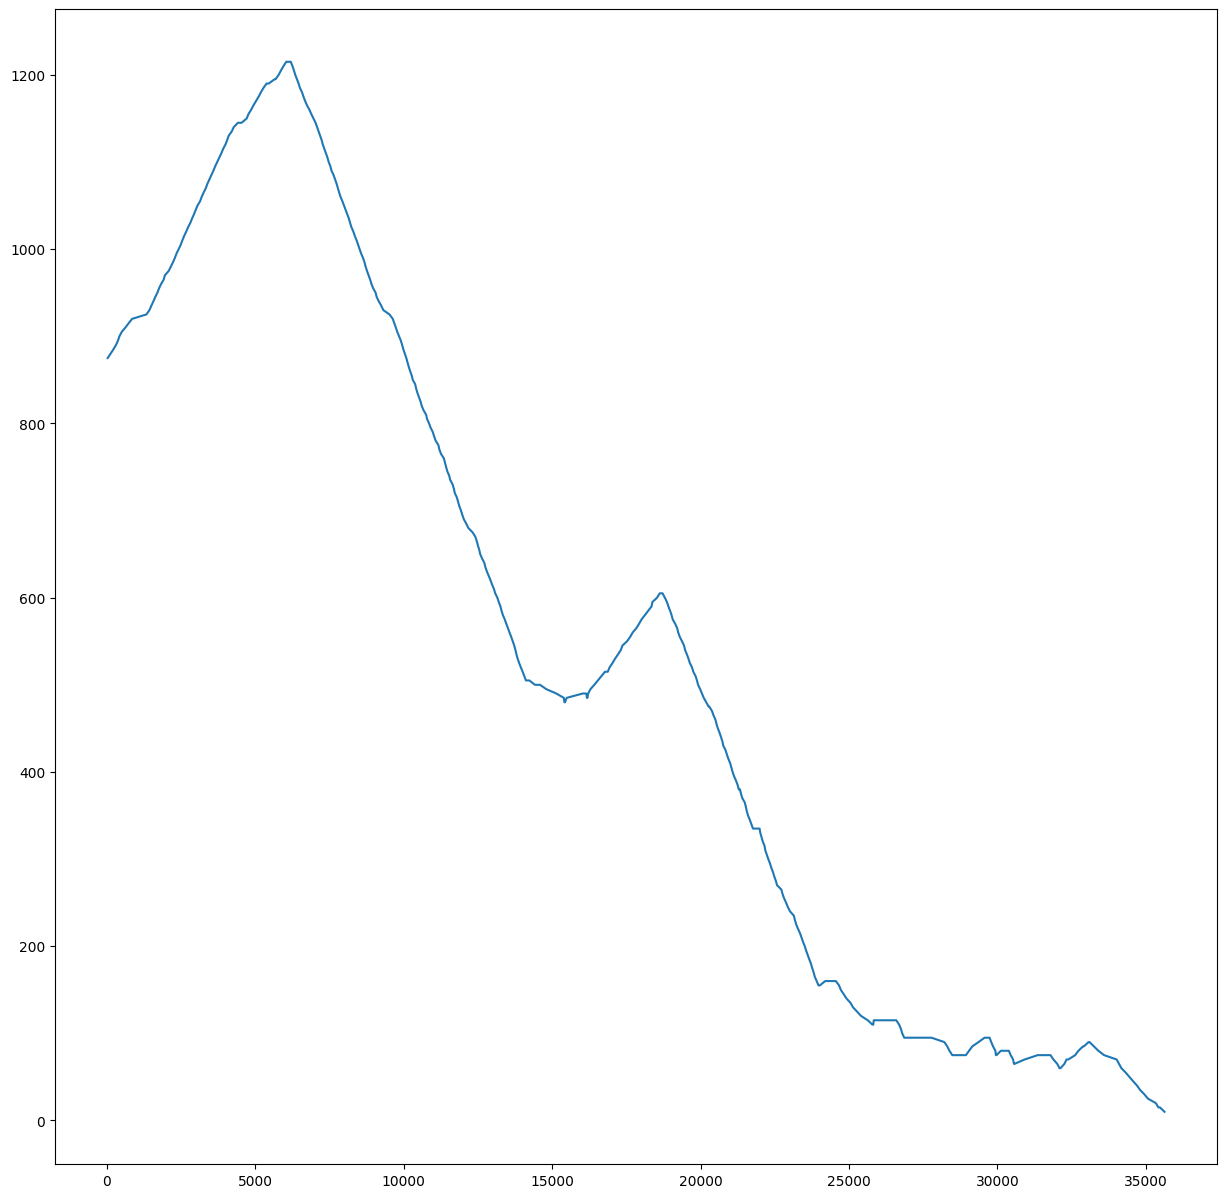

In [9]:
plt.rcParams['figure.figsize']=(15,15)
edge=edges[-1]
edge_df=intersection[intersection.edge==edge]
print(len(edge_df))
edge_df=edge_df.sort_values('edge_coordinate')
begin,end=edge_df.iloc[0]['geometry'],edge_df.iloc[-1]['geometry']
print(begin.y,begin.x)
print(end.y,end.x)
X,Y=np.array(edge_df['edge_coordinate']),np.array(edge_df['elevation'])
dY=np.diff(Y)
d_pos,deg=np.sum(np.where(dY>0,dY,0)),np.sum(np.where(dY<0,dY,0))
print('min:%f, max:%f, d+:%f, d-:%f'%(np.min(Y),np.max(Y),d_pos,deg))
plt.plot(X,Y)

min:10.000000, max:1215.000000, d+:525.000000, d-:-1390.000000


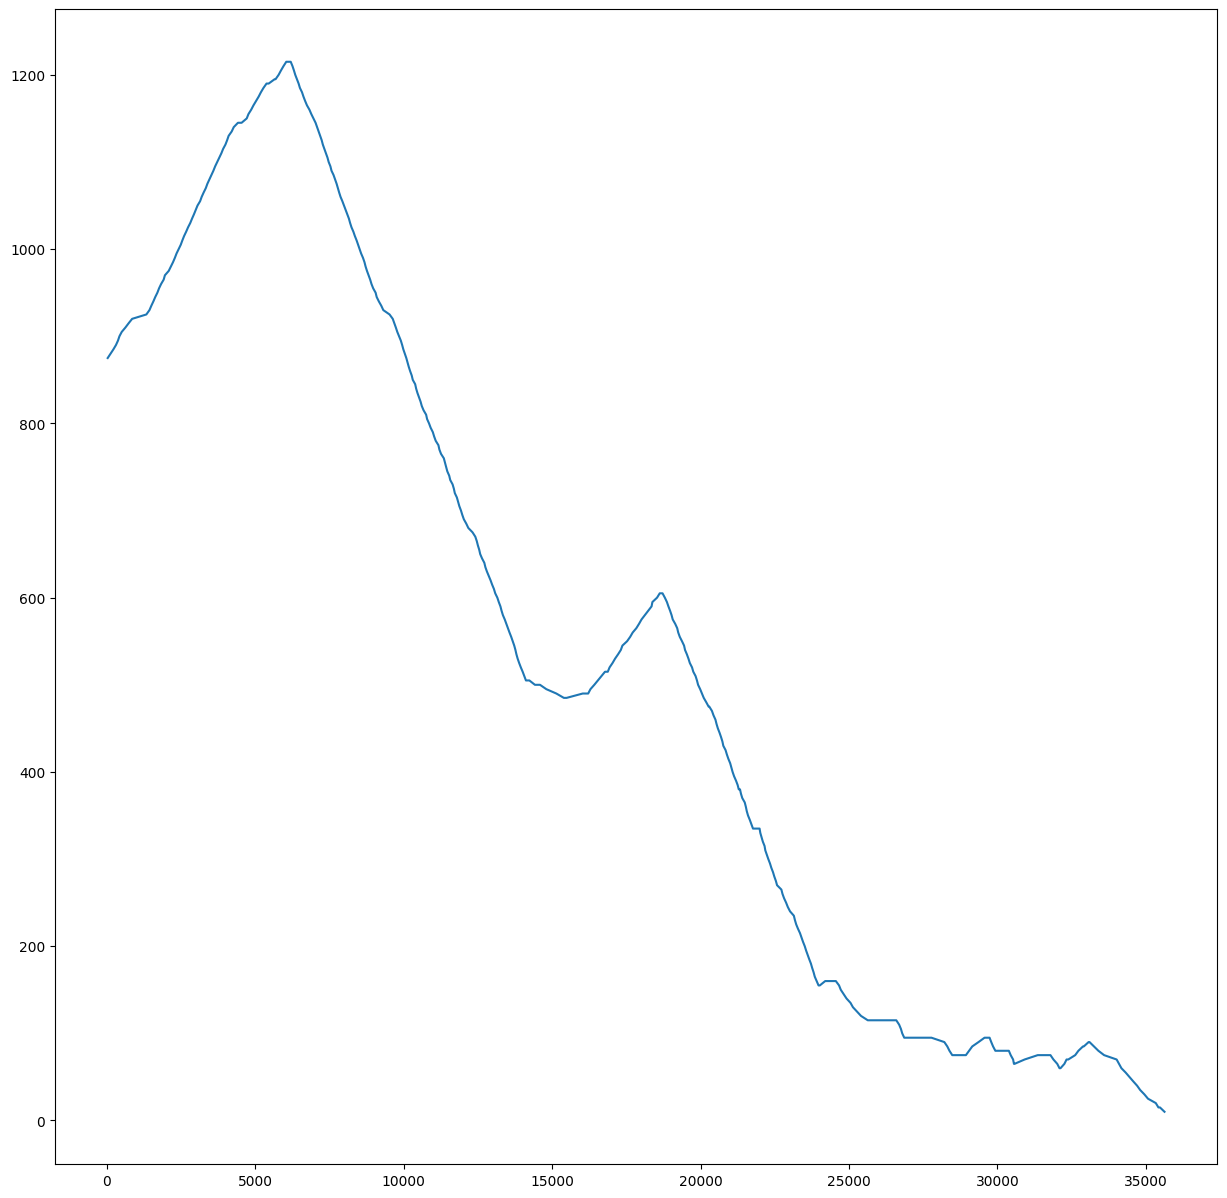

In [10]:
thresh=0.005
indexes=np.where(np.abs(np.gradient(np.gradient(Y,X),X))<=thresh)
X,Y=X[indexes],Y[indexes]
dY=np.diff(Y)
d_pos,deg=np.sum(np.where(dY>0,dY,0)),np.sum(np.where(dY<0,dY,0))
print('min:%f, max:%f, d+:%f, d-:%f'%(np.min(Y),np.max(Y),d_pos,deg))
plt.plot(X,Y)

In [11]:
thresh,min_df_size=0.005,1
t1=time.time()
bad_ids=[]
for edge in edges[::-1]:
    edge_df=intersection[intersection.edge==edge]
    if len(edge_df)>min_df_size:
        edge_df=edge_df.sort_values('edge_coordinate')
        X,Y=np.array(edge_df['edge_coordinate']),np.array(edge_df['elevation'])
        indexes=np.where(np.abs(np.gradient(np.gradient(Y,X),X))>thresh)
        bad_ids+=list(edge_df.index[indexes])
t2=time.time()
print(t2-t1)

/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/pierre/anaconda3/conda/envs/pygmt/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/pie

101.72736287117004


In [20]:
len(bad_ids)/len(intersection)

0.016618897656369792

In [13]:
DELETE=True
if DELETE:
    t1=time.time()
    cmd="""DELETE FROM %s WHERE id IN  %s ;"""%(intersections_table_name,str(tuple(bad_ids)))
    cursor.execute(cmd)
    t2=time.time()
    print(t2-t1)

0.05766892433166504
